In [5]:
# Bibliotecas Basicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import janitor
import re
import ipywidgets as widgets
from IPython.display import display
import warnings

#Time Series Forecasting
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality, plot_residuals_analysis, extract_trend_and_seasonality
from darts.dataprocessing.transformers import Scaler, BoxCox, WindowTransformer
from sklearn.preprocessing import MinMaxScaler , RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from darts.metrics import mape, mae
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


#Models
#from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from darts.models import NHiTSModel
from darts.models import AutoARIMA
from darts.models import ExponentialSmoothing
from darts.models import TiDEModel
from darts.models import LightGBMModel
from darts.models import NLinearModel
from darts.models import DLinearModel
from darts.models import FourTheta
from darts.models import Prophet
from darts.models import Croston
#from darts.models import TSMixerModel
from darts.models import LightGBMModel
from darts.models import NaiveEnsembleModel
import lightgbm
import prophet

#torch
import torch
from chronos import ChronosPipeline


sns.set_style('whitegrid')
sns.set_palette('cubehelix')
warnings.filterwarnings("ignore")

## Import dos Dados

In [6]:
df = pd.read_csv('../data/02.intermediate/forms_results.csv', sep=';', decimal=',')
df = df[['date', 'controle_sobre_tempo', 'impacto_realizacao_pessoal']].copy()
df

date  controle_sobre_tempo  impacto_realizacao_pessoal
0    2023-01-01                  2.75                    2.166667
1    2023-01-02                  3.00                    2.500000
2    2023-01-03                  3.00                    2.833333
3    2023-01-04                  2.25                    2.000000
4    2023-01-05                  1.50                    2.666667
..          ...                   ...                         ...
573  2024-07-27                  1.25                    2.833333
574  2024-07-28                  1.50                    2.666667
575  2024-07-29                  2.00                    3.000000
576  2024-07-30                  1.75                    2.833333
577  2024-07-31                  3.00                    2.166667

[578 rows x 3 columns]

### Plot da Série de Controle Sobre o Tempo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


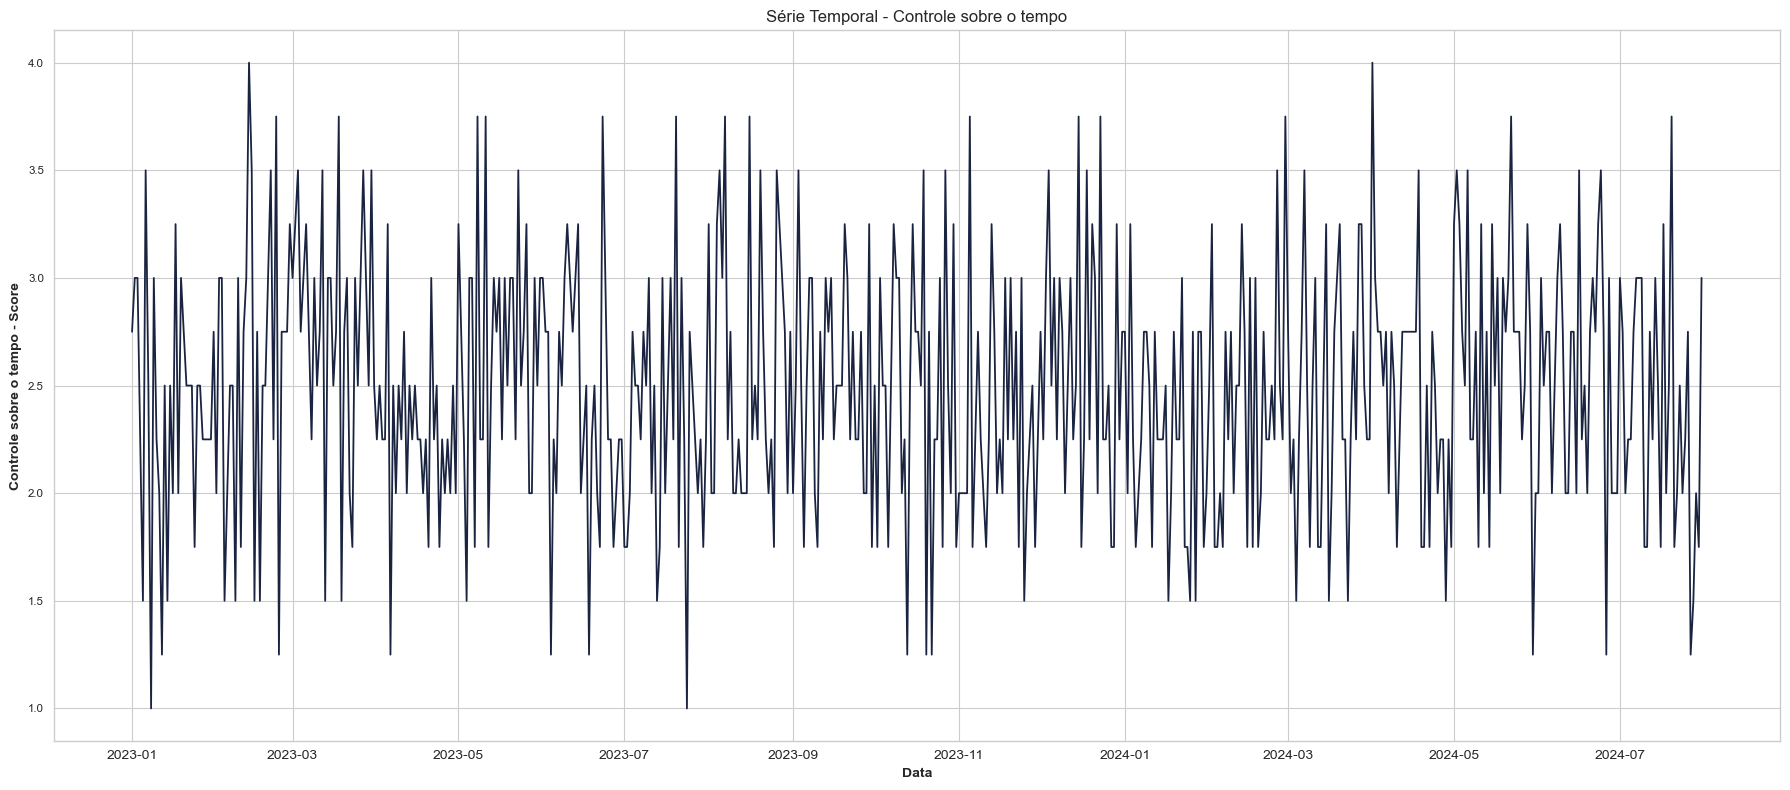

In [7]:
# Plot serie - Controle sobre o tempo
plt.figure(figsize=(18,8))
plt.title('Série Temporal - Controle sobre o tempo')
sns.lineplot(
    x=pd.to_datetime(df['date']),
    y='controle_sobre_tempo',
    data=df
)
plt.ylabel('Controle sobre o tempo - Score')
plt.xlabel('Data')
plt.xticks(fontsize= 10)  # Definindo o tamanho dos rótulos do eixo x
plt.tight_layout()
plt.legend()
plt.show()

### Plot da Série de Impacto e Realização Pessoal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


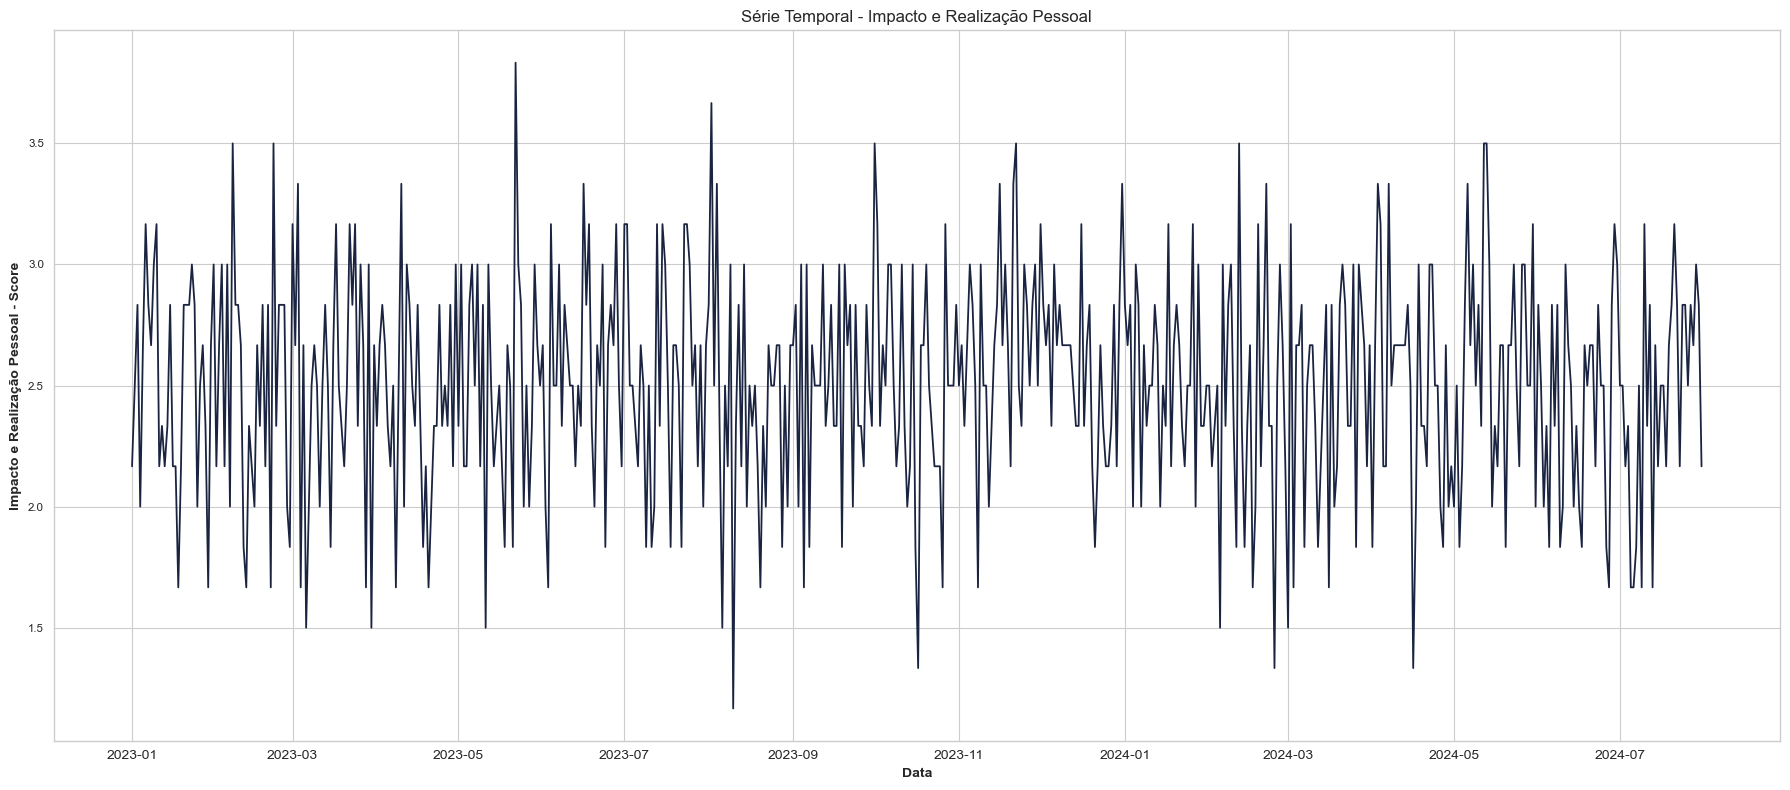

In [8]:
# Plot serie - Controle sobre o tempo
plt.figure(figsize=(18,8))
plt.title('Série Temporal - Impacto e Realização Pessoal')
sns.lineplot(
    x=pd.to_datetime(df['date']),
    y='impacto_realizacao_pessoal',
    data=df
)
plt.ylabel('Impacto e Realização Pessoal - Score')
plt.xlabel('Data')
plt.xticks(fontsize= 10)  # Definindo o tamanho dos rótulos do eixo x
plt.tight_layout()
plt.legend()
plt.show()

## Funções Necessárias

In [9]:
def preprocessing_time_series(time_series,metric): 

    #min_max =   MinMaxScaler(feature_range= (0,1))
    #transformer = Scaler(min_max)
    #time_series_adj = transformer.fit_transform(time_series)
    time_series_adj = time_series

    #features calculadas
    ts_df = time_series_adj.pd_dataframe().reset_index()
    ts_df['rolling_score'] = ts_df[metric].rolling(16).mean()
    ts_df['rolling_score_long'] = ts_df[metric].rolling(32).mean()
    ts_df['rolling_score_std'] = ts_df[metric].rolling(16).std()
    ts_df['rolling_score_long'] = ts_df[metric].rolling(32).std()
    ts_df = ts_df.fillna(0).replace([-np.inf, np.inf], 0)


    #features de tempo 
    time_series_adj = TimeSeries.from_dataframe(ts_df, time_col= 'date')
    time_series_adj = time_series_adj.add_holidays("BR")
    time_series_adj = time_series_adj.add_datetime_attribute("quarter", cyclic= True)
    time_series_adj = time_series_adj.add_datetime_attribute("month", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("day_of_week", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("day_of_year", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("week_of_year", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute('year', cyclic= False)
    time_series_adj = time_series_adj.add_datetime_attribute('is_year_end')
    time_series_adj = time_series_adj.add_datetime_attribute("is_month_start")
    time_series_adj = time_series_adj.add_datetime_attribute("is_month_end")
    time_series_adj = time_series_adj.add_datetime_attribute("weekday", cyclic  = True)

    return time_series_adj #, transformer

In [10]:
def generate_cols_2_drop(timeseries, metric):
    target = metric
    cols_2_drop = timeseries.pd_dataframe()
    cols_2_drop = list(cols_2_drop.drop(columns = target).columns)

    return cols_2_drop

In [11]:

def evaluate_models(models, train, test, past_cov_train, past_cov_test ,cols_2_drop,title_name):

    best_model_dict = {}

    # Definindo subplot
    fig, axs = plt.subplots(len(models), 1, figsize=(14, 17))

    # Iterando sobre os modelos
    for i, (name, model) in enumerate(models.items()):

        # Treinando o modelo
        target = train.drop_columns(cols_2_drop)


        try:
                 
            model.fit(target, past_covariates= past_cov_train) #past_covariates= past_cov

            # Realizando previsões
            y_pred = model.predict(n=len(test), past_covariates= past_cov_train) #past_covariates= past_cov

        except:

            model.fit(target)
                    
            # Realizando previsões
            y_pred = model.predict(n=len(test))



        #Df dos dados
        train_df = train.pd_dataframe()
        test_df = test.pd_dataframe()
        pred_df = y_pred.pd_dataframe()
        
        # train_df['leitos_ocupados_totais'] = rescale_column(train_df, scaler, 'leitos_ocupados_totais')
        # test_df['leitos_ocupados_totais'] = rescale_column(test_df, scaler, 'leitos_ocupados_totais')
        # pred_df['leitos_ocupados_totais'] = rescale_column(pred_df, scaler, 'leitos_ocupados_totais')
    
        # Calculando o erro quadrático médio
        mae_score = mean_absolute_error(test_df[title_name].values, pred_df[title_name].values)
        mae_score = np.round(mae_score,4)

        best_model_dict[mae_score] = name


        # Plotando série histórica preditiva versus série histórica estimada
        axs[i].plot(train_df[title_name], label='Série Histórica Treino')
        axs[i].plot(test_df[title_name], label='Série Histórica Teste')
        axs[i].plot(pred_df[title_name], label=f'Série Histórica Estimada (MSE={mae_score:.2f})')
        #axs[i].axhline(y=15, color='red', linestyle='dotted')
        axs[i].set_title(f'Modelo: {name}')
        axs[i].legend(loc='lower left', fontsize='small', facecolor='white')

    # Adicionando título e legendas aos gráficos
    fig.suptitle(f'Serie Temporal: {title_name}', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return best_model_dict

## Modelo Preditivo - Controle Sobre o Tempo

In [12]:
split_prop = 0.885
train_loc = int(df.shape[0] * split_prop) 
test_loc =  df.shape[0] - train_loc

ts = df.set_index('date')[['controle_sobre_tempo']]
ts_train = ts.iloc[:train_loc,:] 
ts_test = ts.iloc[train_loc:, :]

ts_train = ts_train.reset_index()
ts_test = ts_test.reset_index()

print(ts_train.tail(10))
print("----------------------------------------")
print(ts_test.head(10))

           date  controle_sobre_tempo
501  2024-05-16                  2.50
502  2024-05-17                  3.00
503  2024-05-18                  2.00
504  2024-05-19                  3.00
505  2024-05-20                  2.75
506  2024-05-21                  3.00
507  2024-05-22                  3.75
508  2024-05-23                  2.75
509  2024-05-24                  2.75
510  2024-05-25                  2.75
----------------------------------------
         date  controle_sobre_tempo
0  2024-05-26                  2.25
1  2024-05-27                  2.50
2  2024-05-28                  3.25
3  2024-05-29                  2.75
4  2024-05-30                  1.25
5  2024-05-31                  2.00
6  2024-06-01                  2.00
7  2024-06-02                  3.00
8  2024-06-03                  2.50
9  2024-06-04                  2.75


In [13]:
print(
    "-------------------------------------",
    '\n',
    f"Dados de treinamento: {ts_train.shape[0]}",
    '\n',
    f"Dados de Teste: {ts_test.shape[0]}",
    '\n',
    "--------------------------------------"
)

------------------------------------- 
 Dados de treinamento: 511 
 Dados de Teste: 67 
 --------------------------------------


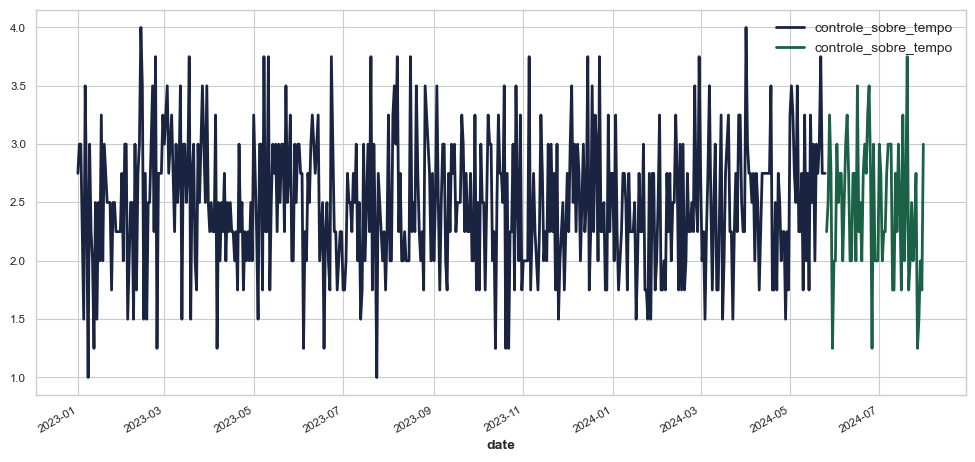

In [14]:
#Timeseries Object
ts_darts_train = TimeSeries.from_dataframe(ts_train, time_col  = 'date', value_cols= 'controle_sobre_tempo')
ts_darts_test = TimeSeries.from_dataframe(ts_test, time_col  = 'date', value_cols= 'controle_sobre_tempo')

#Figure Plot
plt.figure(figsize= (12,5))
ts_darts_train.plot()
ts_darts_test.plot()
plt.legend()
plt.show()

In [15]:
#Check de Sazonalidade
seasonal_order = []
for m in range(2, 61):
    is_seasonal, period = check_seasonality(ts_darts_train, m=m, max_lag= 61, alpha=0.05)
    if is_seasonal:
        seasonal_order.append(period)
        print("There is seasonality of order {}.".format(period))


There is seasonality of order 3.
There is seasonality of order 6.
There is seasonality of order 9.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 20.
There is seasonality of order 25.
There is seasonality of order 28.
There is seasonality of order 31.
There is seasonality of order 37.
There is seasonality of order 43.
There is seasonality of order 45.
There is seasonality of order 48.
There is seasonality of order 55.
There is seasonality of order 57.
There is seasonality of order 60.


### Teste do Darts

In [16]:
#Preprocessing
ts_darts_train = preprocessing_time_series(ts_darts_train,'controle_sobre_tempo')
ts_darts_test = preprocessing_time_series(ts_darts_test,'controle_sobre_tempo')

In [17]:
cols_2_drop = generate_cols_2_drop(ts_darts_train,'controle_sobre_tempo')
cols_2_drop

['rolling_score',
 'rolling_score_long',
 'rolling_score_std',
 'holidays',
 'quarter_sin',
 'quarter_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'year',
 'is_year_end',
 'is_month_start',
 'is_month_end',
 'weekday_sin',
 'weekday_cos']

In [18]:
#Past Covariates
past_covariates_train = ts_darts_train.drop_columns('controle_sobre_tempo')
past_covariates_test = ts_darts_test.drop_columns('controle_sobre_tempo')

In [19]:

# Inicializando modelos
try:
    seasonal_array = np.array(seasonal_order)
    try:
        season_value = seasonal_array[(seasonal_array >= 20) & (seasonal_array < 30)][0]
    except:
        try:
            season_value = seasonal_array[(seasonal_array >= 15) & (seasonal_array < 35)][0]
        except:
            season_value = seasonal_array[-1]
except:
    season_value =  60

#Early Stopper
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.05,
    mode='min',
)

global_params = {
    'output_chunk': len(ts_darts_test),
    'input_chunk': int(season_value),
     'epocas': 10
}



models = {

    "N-Hits": NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 128, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),
                        
     "N-Linear": NLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn = torch.nn.MSELoss(),
                         random_state = 42,
                         ),

     "TiDe": TiDEModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         ),
                        
     "D-linear": DLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn =torch.nn.MSELoss(),
                         random_state = 42),
                        
    "Exponencial": ExponentialSmoothing(random_state = 42,
                                         seasonal_periods = 7,
                                        trend=ModelMode.ADDITIVE,
                                        seasonal=SeasonalityMode.ADDITIVE),
                                        
    "Theta": FourTheta(trend_mode= TrendMode.EXPONENTIAL,
                       theta  = 4,
                       seasonality_period  = int(season_value),
                        season_mode= SeasonalityMode.ADDITIVE),

    "Ensembled": NaiveEnsembleModel([
        NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 256, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),         
        ExponentialSmoothing(random_state = 42,
                            seasonal_periods = int(season_value),
                            trend=ModelMode.ADDITIVE,
                            seasonal=SeasonalityMode.ADDITIVE),    
        ])          

}


Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 368 K 
---------------------------------------------------
313 K     Trainable params
54.2 K    Non-trainable params
368 K     Total params
1.472     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 28.2 K
---------------------------------------------------
28.2 K    Trainable params
0         Non-trainable params
28.2 K    Total params
0.113     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 3.3 K 
4 | encoders            | Sequential       | 42.4 K
5 | decoders            | Sequential       | 293 K 
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 1.4 K 
---------------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.363     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 28.2 K
5 | linear_trend    | Linear           | 28.2 K
-----------------------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.226     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 865 K 
---------------------------------------------------
757 K     Trainable params
107 K     Non-trainable params
865 K     Total params
3.461     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

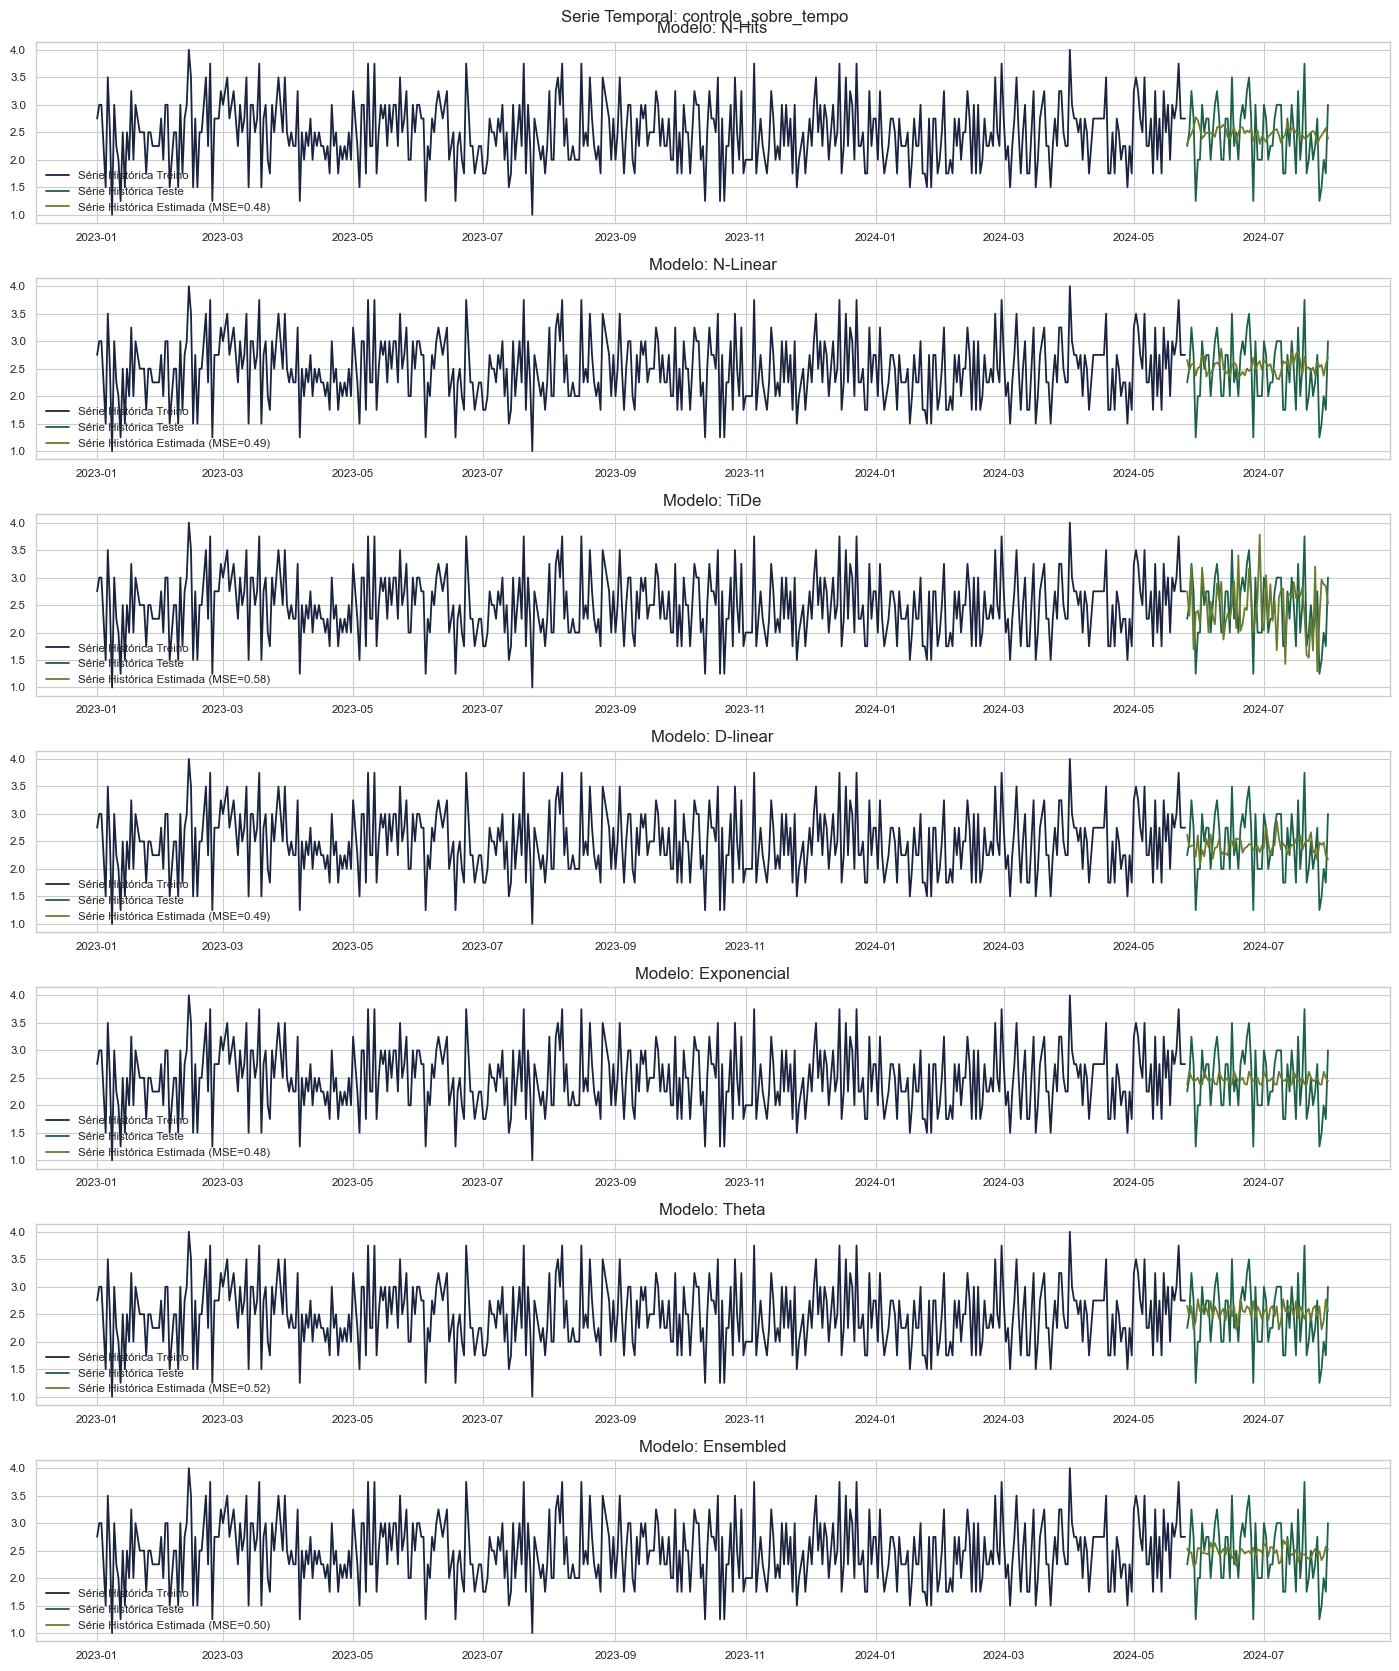

In [20]:
#Train, Test and plot

best_model_dict = evaluate_models(models,
                                ts_darts_train,
                                ts_darts_test,
                                past_covariates_train,
                                past_covariates_test,
                                cols_2_drop,
                                'controle_sobre_tempo'
                                )


### Teste do Amazon Chronos

In [21]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [22]:
pred_len = len(ts_test)
contexto = torch.tensor(ts_train['controle_sobre_tempo'])
forecast = pipeline.predict(
    context= contexto,
    prediction_length= pred_len,
    num_samples= 15,
    limit_prediction_length = False,
)

In [23]:
fc_index = pd.date_range(start=pd.to_datetime(ts_train.date.iloc[-1]) + pd.Timedelta(days=1), periods= pred_len, freq='D')
fc_index


DatetimeIndex(['2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02',
               '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30',
               '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04',
               '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08',
               '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
               '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16',
               '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20',
      

In [24]:
low, median, high = np.quantile(forecast[0].numpy(), [0.10, 0.5, 0.90], axis=0)
mean_pred = np.mean(forecast[0].numpy(), axis = 0)

y_pred = pd.DataFrame(data= mean_pred,
                     index=fc_index).rename(columns= {0:'controle_sobre_tempo'})

y_pred['10_percentile'] = low
y_pred['90_percentile'] = high

y_pred

controle_sobre_tempo  10_percentile  90_percentile
2024-05-26              2.632125       2.099867       3.499778
2024-05-27              2.700177       1.851967       3.754972
2024-05-28              2.600530       2.099867       3.007623
2024-05-29              2.798608       2.099867       3.499778
2024-05-30              2.883672       2.099867       3.652895
...                          ...            ...            ...
2024-07-27              2.500884       2.005082       3.244586
2024-07-28              2.549492       1.596775       4.345560
2024-07-29              2.568142       2.242087       3.095693
2024-07-30              2.546161       2.194461       2.901524
2024-07-31              2.679270       2.091882       3.242234

[67 rows x 3 columns]

In [25]:
#inverse transform das series

ts_train_adj = ts_train.copy()
ts_train_adj = ts_train_adj.set_index("date")


ts_test_adj = ts_test.copy()
ts_test_adj = ts_test_adj.set_index("date")


In [26]:
#Calculo das métricas de erro 

erro  = mean_absolute_error(ts_test_adj['controle_sobre_tempo'].values,
                             y_pred['controle_sobre_tempo'].values)
erro = np.round(erro, 2)

print(
    "------------------------------------",
    '\n',
    f"Erro de predição: {erro} do score em média",
    '\n',
    "------------------------------------",
)

------------------------------------ 
 Erro de predição: 0.52 do score em média 
 ------------------------------------


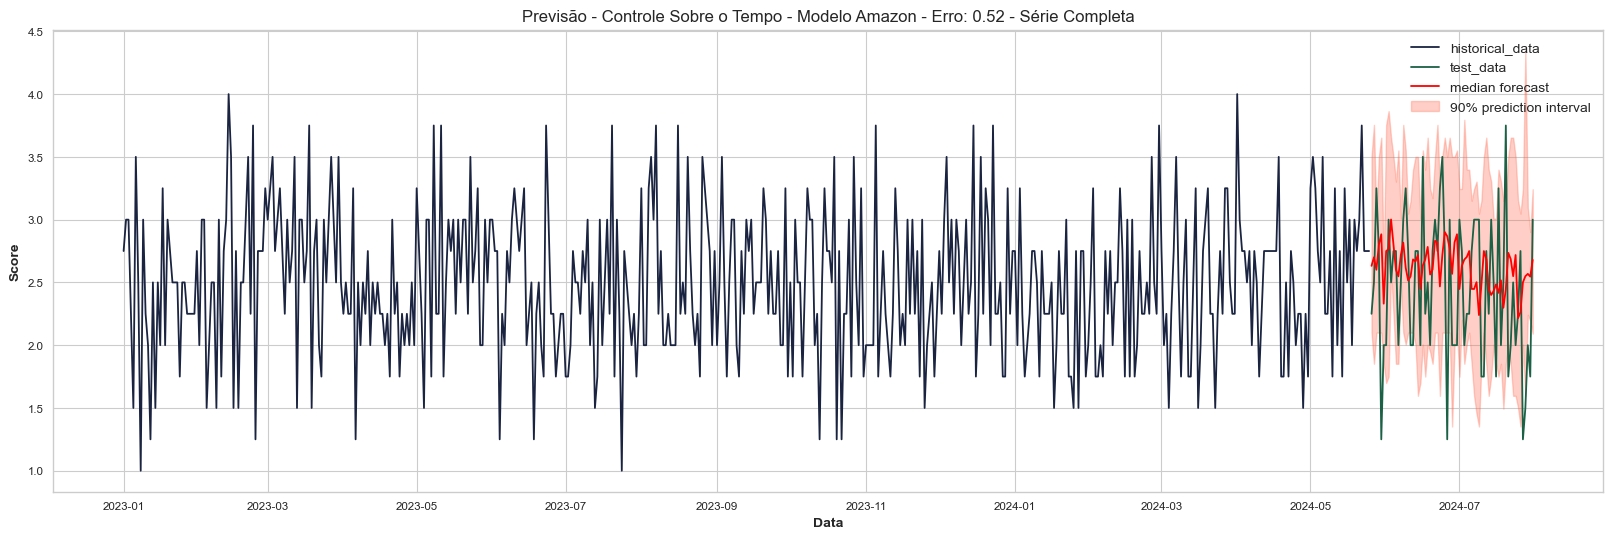

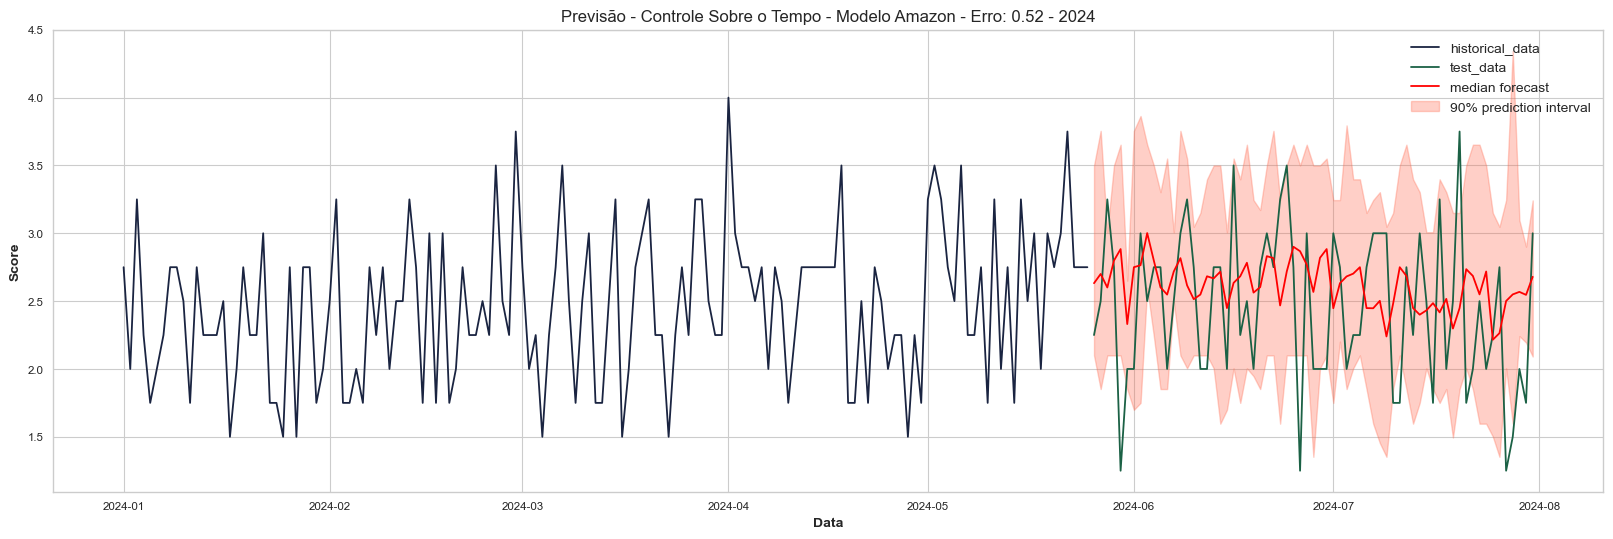

In [27]:
y_pred_adj = y_pred
y_pred_adj['date'] = pd.to_datetime(y_pred_adj.index)
y_pred_adj.rename(columns={'controle_sobre_tempo':'controle_sobre_tempo_pred'}, inplace=True)

ts_train_adj['label'] = 'historical_data'
ts_test_adj['label'] = 'test_data'

ts_full = pd.concat([ts_train_adj,ts_test_adj]).reset_index()
ts_full['date'] = pd.to_datetime(ts_full['date'])

df_plot = ts_full.merge(y_pred_adj, left_on='date', right_on='date', how='left')

plt.figure(figsize=(20,6))
plt.title(f"Previsão - Controle Sobre o Tempo - Modelo Amazon - Erro: {erro} - Série Completa")
sns.lineplot(x='date', y='controle_sobre_tempo', hue='label', data=df_plot)
sns.lineplot(x='date', y='controle_sobre_tempo_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

df_plot = df_plot[df_plot.date.dt.year==2024].copy()

plt.figure(figsize=(20,6))
plt.title(f"Previsão - Controle Sobre o Tempo - Modelo Amazon - Erro: {erro} - 2024")
sns.lineplot(x='date', y='controle_sobre_tempo', hue='label', data=df_plot)
sns.lineplot(x='date', y='controle_sobre_tempo_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

del df_plot
del ts_full

## Modelo Preditivo - Impacto e Realização Pessoal

In [28]:
split_prop = 0.885
train_loc = int(df.shape[0] * split_prop) 
test_loc =  df.shape[0] - train_loc

ts = df.set_index('date')[['impacto_realizacao_pessoal']]
ts_train = ts.iloc[:train_loc,:] 
ts_test = ts.iloc[train_loc:, :]

ts_train = ts_train.reset_index()
ts_test = ts_test.reset_index()

print(ts_train.tail(10))
print("----------------------------------------")
print(ts_test.head(10))

           date  impacto_realizacao_pessoal
501  2024-05-16                    2.333333
502  2024-05-17                    2.166667
503  2024-05-18                    2.666667
504  2024-05-19                    2.666667
505  2024-05-20                    1.833333
506  2024-05-21                    2.666667
507  2024-05-22                    2.666667
508  2024-05-23                    3.000000
509  2024-05-24                    2.500000
510  2024-05-25                    2.166667
----------------------------------------
         date  impacto_realizacao_pessoal
0  2024-05-26                    3.000000
1  2024-05-27                    3.000000
2  2024-05-28                    2.500000
3  2024-05-29                    2.500000
4  2024-05-30                    3.166667
5  2024-05-31                    2.000000
6  2024-06-01                    2.833333
7  2024-06-02                    2.500000
8  2024-06-03                    2.000000
9  2024-06-04                    2.333333


In [29]:
print(
    "-------------------------------------",
    '\n',
    f"Dados de treinamento: {ts_train.shape[0]}",
    '\n',
    f"Dados de Teste: {ts_test.shape[0]}",
    '\n',
    "--------------------------------------"
)

------------------------------------- 
 Dados de treinamento: 511 
 Dados de Teste: 67 
 --------------------------------------


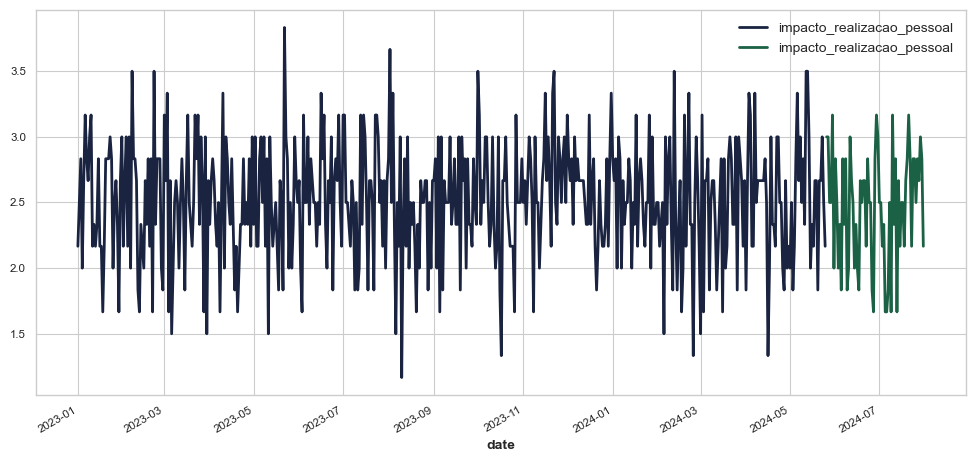

In [30]:
#Timeseries Object
ts_darts_train = TimeSeries.from_dataframe(ts_train, time_col  = 'date', value_cols= 'impacto_realizacao_pessoal')
ts_darts_test = TimeSeries.from_dataframe(ts_test, time_col  = 'date', value_cols= 'impacto_realizacao_pessoal')

#Figure Plot
plt.figure(figsize= (12,5))
ts_darts_train.plot()
ts_darts_test.plot()
plt.legend()
plt.show()

In [31]:
#Check de Sazonalidade
seasonal_order = []
for m in range(2, 61):
    is_seasonal, period = check_seasonality(ts_darts_train, m=m, max_lag= 61, alpha=0.05)
    if is_seasonal:
        seasonal_order.append(period)
        print("There is seasonality of order {}.".format(period))


There is seasonality of order 2.
There is seasonality of order 4.
There is seasonality of order 7.
There is seasonality of order 9.
There is seasonality of order 12.
There is seasonality of order 14.
There is seasonality of order 16.
There is seasonality of order 18.
There is seasonality of order 20.
There is seasonality of order 25.
There is seasonality of order 28.
There is seasonality of order 30.
There is seasonality of order 32.
There is seasonality of order 40.
There is seasonality of order 42.
There is seasonality of order 45.
There is seasonality of order 47.
There is seasonality of order 49.
There is seasonality of order 52.
There is seasonality of order 56.
There is seasonality of order 58.


### Teste do Darts

In [32]:
#Preprocessing
ts_darts_train = preprocessing_time_series(ts_darts_train,'impacto_realizacao_pessoal')
ts_darts_test = preprocessing_time_series(ts_darts_test,'impacto_realizacao_pessoal')

In [33]:
cols_2_drop = generate_cols_2_drop(ts_darts_train,'impacto_realizacao_pessoal')
cols_2_drop

['rolling_score',
 'rolling_score_long',
 'rolling_score_std',
 'holidays',
 'quarter_sin',
 'quarter_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'year',
 'is_year_end',
 'is_month_start',
 'is_month_end',
 'weekday_sin',
 'weekday_cos']

In [34]:
#Past Covariates
past_covariates_train = ts_darts_train.drop_columns('impacto_realizacao_pessoal')
past_covariates_test = ts_darts_test.drop_columns('impacto_realizacao_pessoal')

In [35]:

# Inicializando modelos
try:
    seasonal_array = np.array(seasonal_order)
    try:
        season_value = seasonal_array[(seasonal_array >= 20) & (seasonal_array < 30)][0]
    except:
        try:
            season_value = seasonal_array[(seasonal_array >= 15) & (seasonal_array < 35)][0]
        except:
            season_value = seasonal_array[-1]
except:
    season_value =  60

#Early Stopper
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.05,
    mode='min',
)

global_params = {
    'output_chunk': len(ts_darts_test),
    'input_chunk': int(season_value),
     'epocas': 10
}



models = {

    "N-Hits": NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 128, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),
                        
     "N-Linear": NLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn = torch.nn.MSELoss(),
                         random_state = 42,
                         ),

     "TiDe": TiDEModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         ),
                        
     "D-linear": DLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn =torch.nn.MSELoss(),
                         random_state = 42),
                        
    "Exponencial": ExponentialSmoothing(random_state = 42,
                                         seasonal_periods = 7,
                                        trend=ModelMode.ADDITIVE,
                                        seasonal=SeasonalityMode.ADDITIVE),
                                        
    "Theta": FourTheta(trend_mode= TrendMode.EXPONENTIAL,
                       theta  = 4,
                       seasonality_period  = int(season_value),
                        season_mode= SeasonalityMode.ADDITIVE),

    "Ensembled": NaiveEnsembleModel([
        NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 256, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),         
        ExponentialSmoothing(random_state = 42,
                            seasonal_periods = int(season_value),
                            trend=ModelMode.ADDITIVE,
                            seasonal=SeasonalityMode.ADDITIVE),    
        ])          

}


Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 368 K 
---------------------------------------------------
313 K     Trainable params
54.2 K    Non-trainable params
368 K     Total params
1.472     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 28.2 K
---------------------------------------------------
28.2 K    Trainable params
0         Non-trainable params
28.2 K    Total params
0.113     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 3.3 K 
4 | encoders            | Sequential       | 42.4 K
5 | decoders            | Sequential       | 293 K 
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 1.4 K 
---------------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.363     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 28.2 K
5 | linear_trend    | Linear           | 28.2 K
-----------------------------------------------------
56.4 K    Trainable params
0         Non-trainable params
56.4 K    Total params
0.226     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 865 K 
---------------------------------------------------
757 K     Trainable params
107 K     Non-trainable params
865 K     Total params
3.461     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

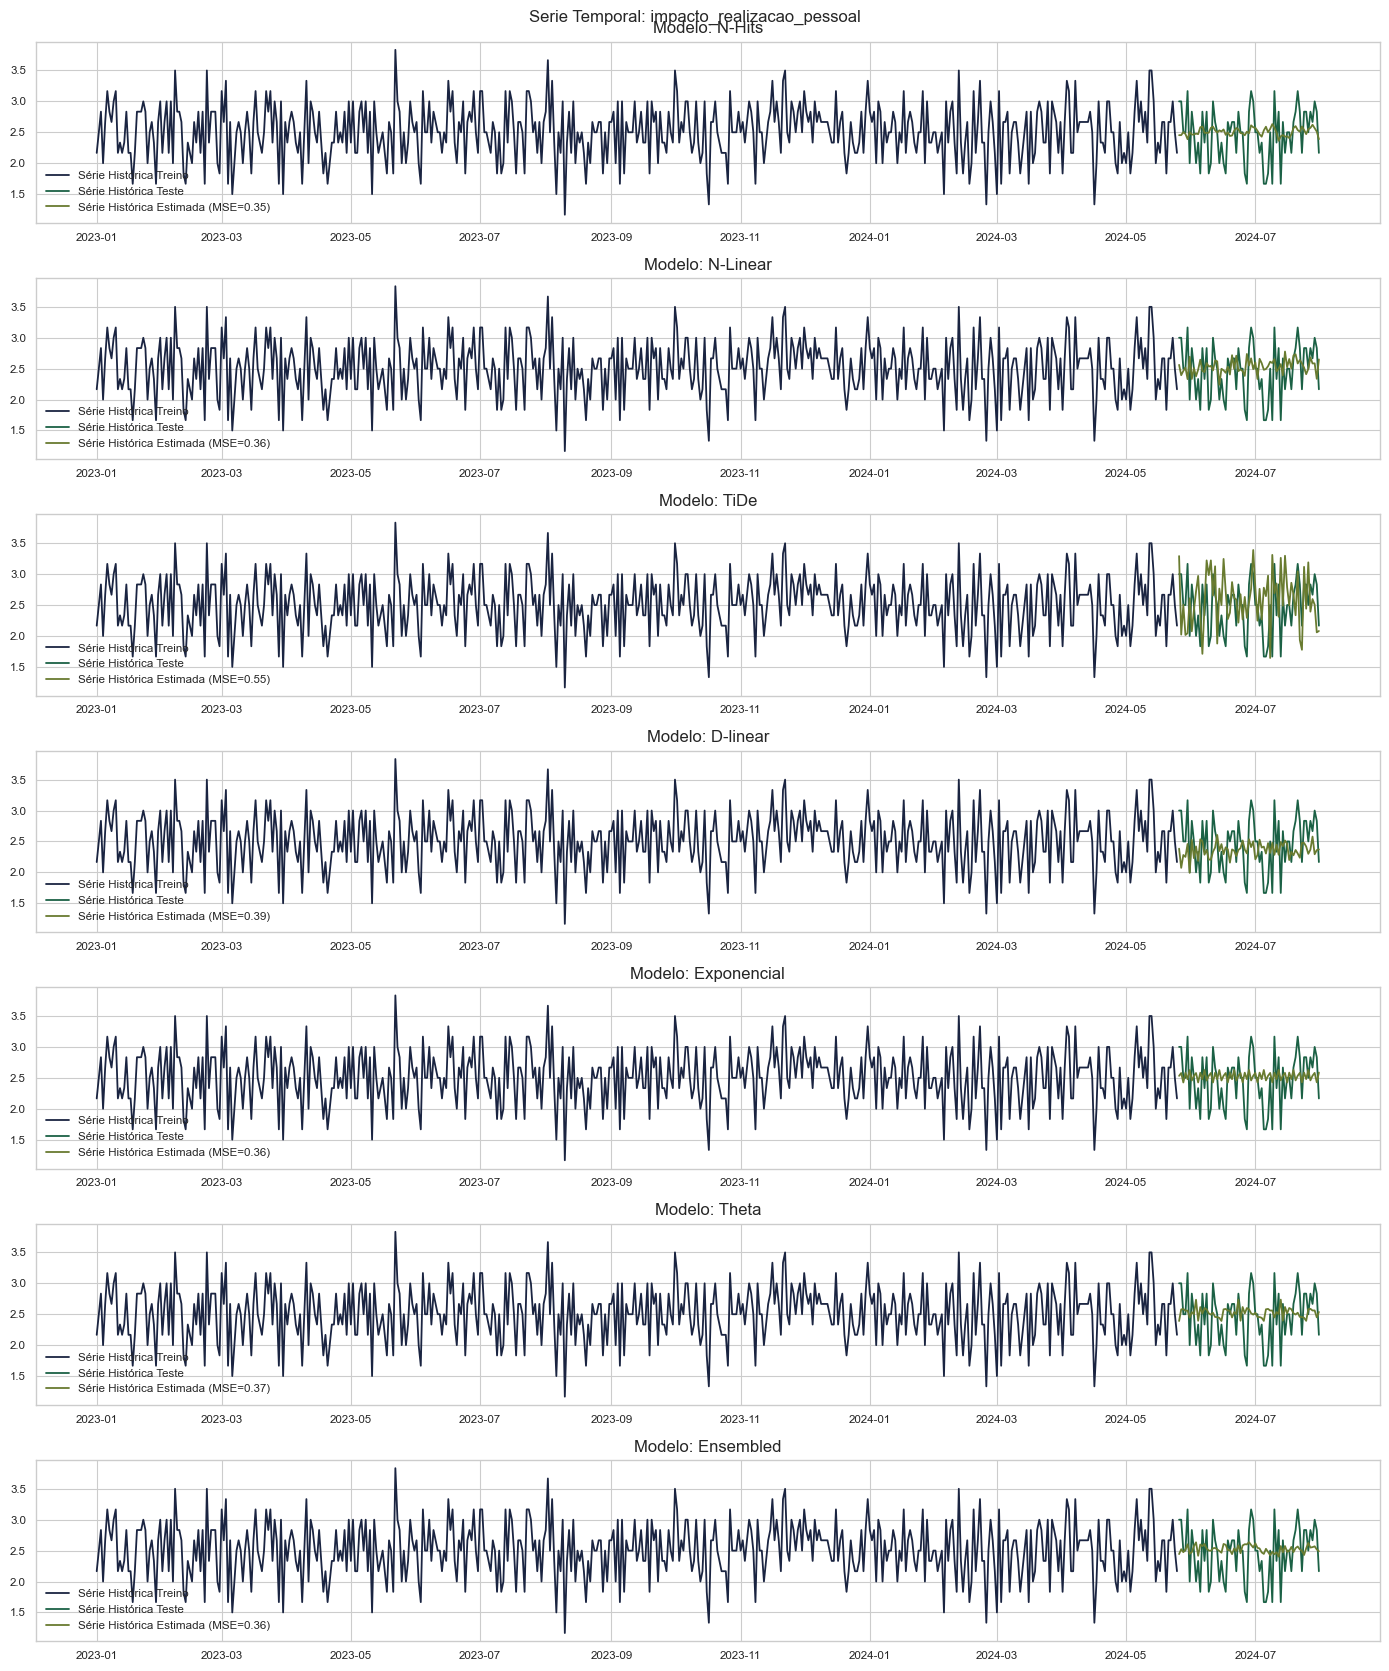

In [36]:
#Train, Test and plot

best_model_dict = evaluate_models(models,
                                ts_darts_train,
                                ts_darts_test,
                                past_covariates_train,
                                past_covariates_test,
                                cols_2_drop,
                                'impacto_realizacao_pessoal'
                                )


### Teste do Amazon Chronos

In [37]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [38]:
pred_len = len(ts_test)
contexto = torch.tensor(ts_train['impacto_realizacao_pessoal'])
forecast = pipeline.predict(
    context= contexto,
    prediction_length= pred_len,
    num_samples= 15,
    limit_prediction_length = False,
)

In [39]:
fc_index = pd.date_range(start=pd.to_datetime(ts_train.date.iloc[-1]) + pd.Timedelta(days=1), periods= pred_len, freq='D')
fc_index

DatetimeIndex(['2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02',
               '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30',
               '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04',
               '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08',
               '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
               '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16',
               '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20',
      

In [40]:
low, median, high = np.quantile(forecast[0].numpy(), [0.10, 0.5, 0.90], axis=0)
mean_pred = np.mean(forecast[0].numpy(), axis = 0)

y_pred = pd.DataFrame(data= mean_pred,
                     index=fc_index).rename(columns= {0:'impacto_realizacao_pessoal'})

y_pred['10_percentile'] = low
y_pred['90_percentile'] = high

y_pred

impacto_realizacao_pessoal  10_percentile  90_percentile
2024-05-26                    2.546871       1.824458       3.269283
2024-05-27                    2.702902       1.865003       3.335627
2024-05-28                    2.527213       2.174608       2.838047
2024-05-29                    2.629186       2.075091       3.169766
2024-05-30                    2.537042       1.898174       3.103423
...                                ...            ...            ...
2024-07-27                    2.505099       2.008747       3.103423
2024-07-28                    2.571443       2.075091       3.136595
2024-07-29                    2.571454       2.339359       2.836704
2024-07-30                    2.593558       2.339359       2.936174
2024-07-31                    2.526018       2.040954       2.936174

[67 rows x 3 columns]

In [41]:
#inverse transform das series

ts_train_adj = ts_train.copy()
ts_train_adj = ts_train_adj.set_index("date")


ts_test_adj = ts_test.copy()
ts_test_adj = ts_test_adj.set_index("date")


In [42]:
#Calculo das métricas de erro 

erro  = mean_absolute_error(ts_test_adj['impacto_realizacao_pessoal'].values,
                             y_pred['impacto_realizacao_pessoal'].values)
erro = np.round(erro, 2)

print(
    "------------------------------------",
    '\n',
    f"Erro de predição: {erro} do score em média",
    '\n',
    "------------------------------------",
)

------------------------------------ 
 Erro de predição: 0.37 do score em média 
 ------------------------------------


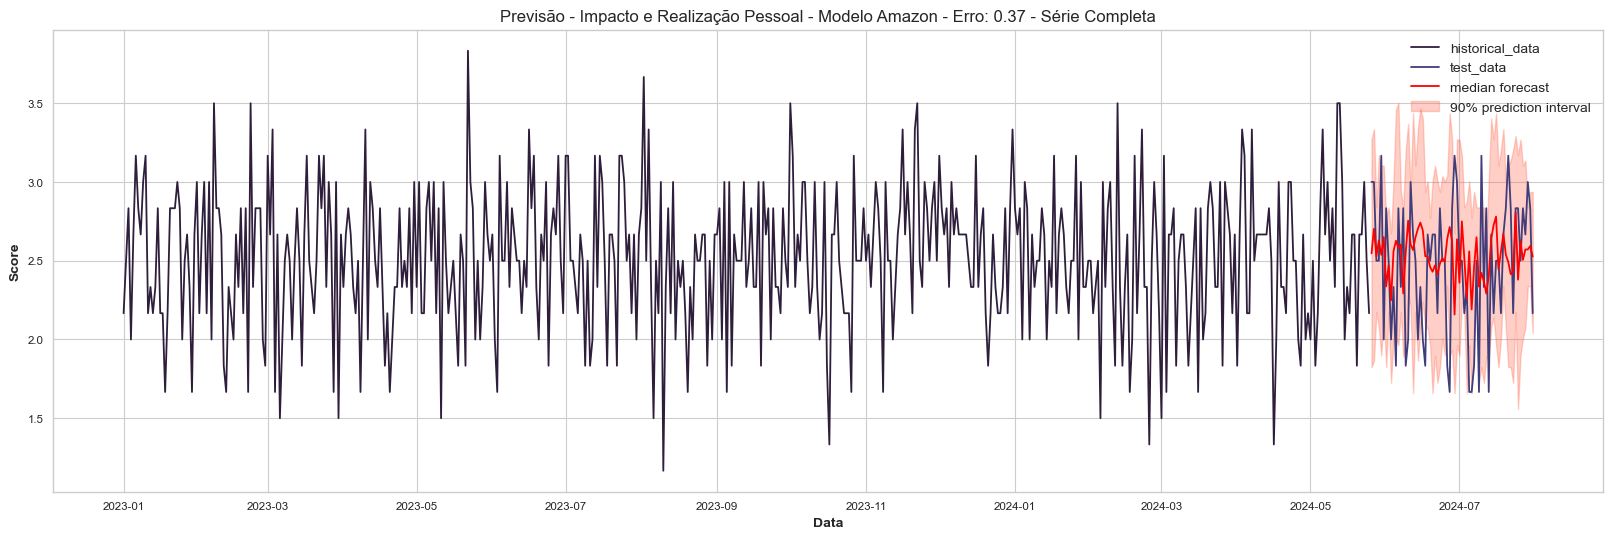

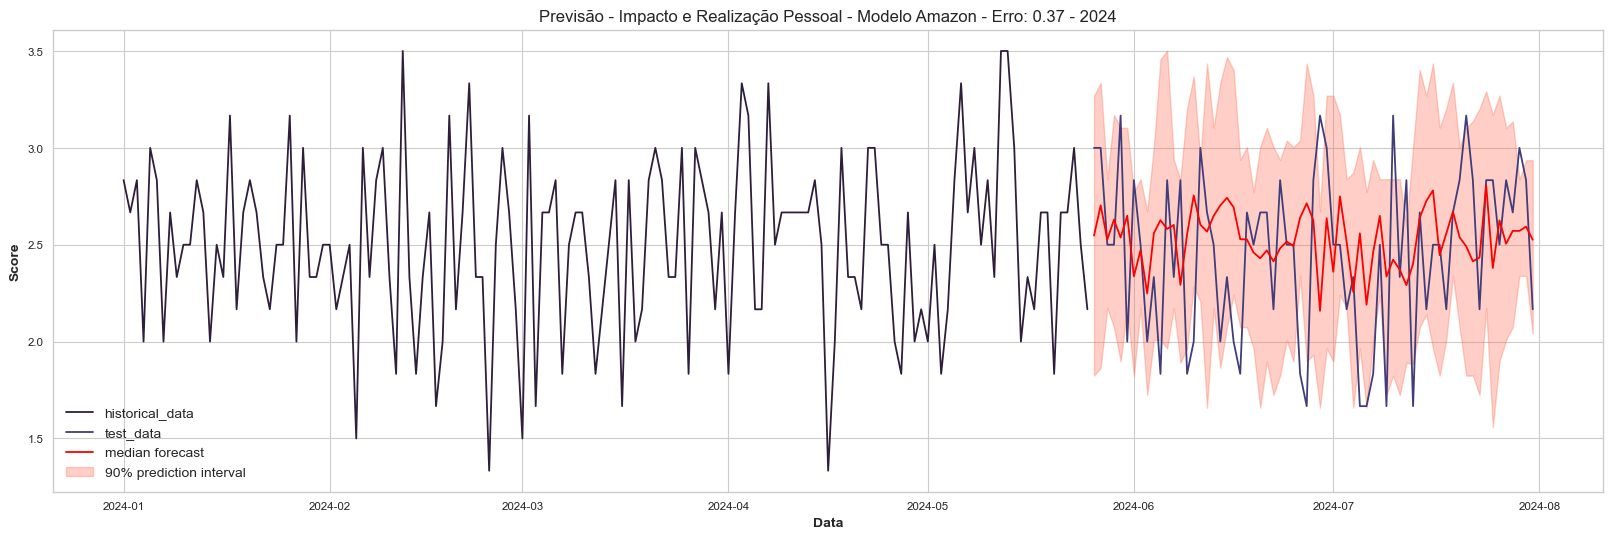

In [43]:
y_pred_adj = y_pred
y_pred_adj['date'] = pd.to_datetime(y_pred_adj.index)
y_pred_adj.rename(columns={'impacto_realizacao_pessoal':'impacto_realizacao_pessoal_pred'}, inplace=True)

ts_train_adj['label'] = 'historical_data'
ts_test_adj['label'] = 'test_data'

ts_full = pd.concat([ts_train_adj,ts_test_adj]).reset_index()
ts_full['date'] = pd.to_datetime(ts_full['date'])

df_plot = ts_full.merge(y_pred_adj, left_on='date', right_on='date', how='left')

plt.figure(figsize=(20,6))
sns.set_palette('mako')
plt.title(f"Previsão - Impacto e Realização Pessoal - Modelo Amazon - Erro: {erro} - Série Completa")
sns.lineplot(x='date', y='impacto_realizacao_pessoal', hue='label', data=df_plot)
sns.lineplot(x='date', y='impacto_realizacao_pessoal_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

df_plot = df_plot[df_plot.date.dt.year==2024].copy()

plt.figure(figsize=(20,6))
sns.set_palette('mako')
plt.title(f"Previsão - Impacto e Realização Pessoal - Modelo Amazon - Erro: {erro} - 2024")
sns.lineplot(x='date', y='impacto_realizacao_pessoal', hue='label', data=df_plot)
sns.lineplot(x='date', y='impacto_realizacao_pessoal_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

del df_plot
del ts_full